In [ ]:
import warnings
from math import exp, log, sqrt
from datetime import datetime
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from scipy.stats import boxcox

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

from xgboost import XGBRegressor

In [ ]:
# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/refs/heads/master/monthly-robberies.csv"
series = pd.read_csv(url, header=0, index_col=0, parse_dates=True)

In [ ]:
!mkdir data
!ls

data  sample_data


In [ ]:
# split into a training and validation dataset
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('data/monthly-robberies-dataset.csv', header=False)
validation.to_csv('data/monthly-robberies-validation.csv', header=False)

Dataset 106, Validation 12


## Persistence model as a baseline model

In [ ]:
# evaluate a persistence model
series = pd.read_csv('data/monthly-robberies-dataset.csv', header=None,
                     index_col=0, parse_dates=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat[0], obs[0]))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=98.000, Expected=125.000
>Predicted=125.000, Expected=155.000
>Predicted=155.000, Expected=190.000
>Predicted=190.000, Expected=236.000
>Predicted=236.000, Expected=189.000
>Predicted=189.000, Expected=174.000
>Predicted=174.000, Expected=178.000
>Predicted=178.000, Expected=136.000
>Predicted=136.000, Expected=161.000
>Predicted=161.000, Expected=171.000
>Predicted=171.000, Expected=149.000
>Predicted=149.000, Expected=184.000
>Predicted=184.000, Expected=155.000
>Predicted=155.000, Expected=276.000
>Predicted=276.000, Expected=224.000
>Predicted=224.000, Expected=213.000
>Predicted=213.000, Expected=279.000
>Predicted=279.000, Expected=268.000
>Predicted=268.000, Expected=287.000
>Predicted=287.000, Expected=238.000
>Predicted=238.000, Expected=213.000
>Predicted=213.000, Expected=257.000
>Predicted=257.000, Expected=293.000
>Predicted=293.000, Expected=212.000
>Predicted=212.000, Expected=246.000
>Predicted=246.000, Expected=353.000
>Predicted=353.000, Expected=339.000
>P

## Data Analysis

### Summary Statistics

In [ ]:
# summary statistics of time series
print(series.describe())

                1
count  106.000000
mean   173.103774
std    112.231133
min     29.000000
25%     74.750000
50%    144.500000
75%    271.750000
max    487.000000


### Line Plot

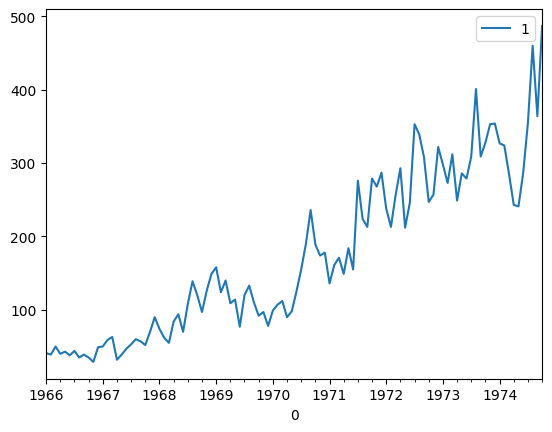

In [ ]:
series.plot()
plt.show()

### Density Plot

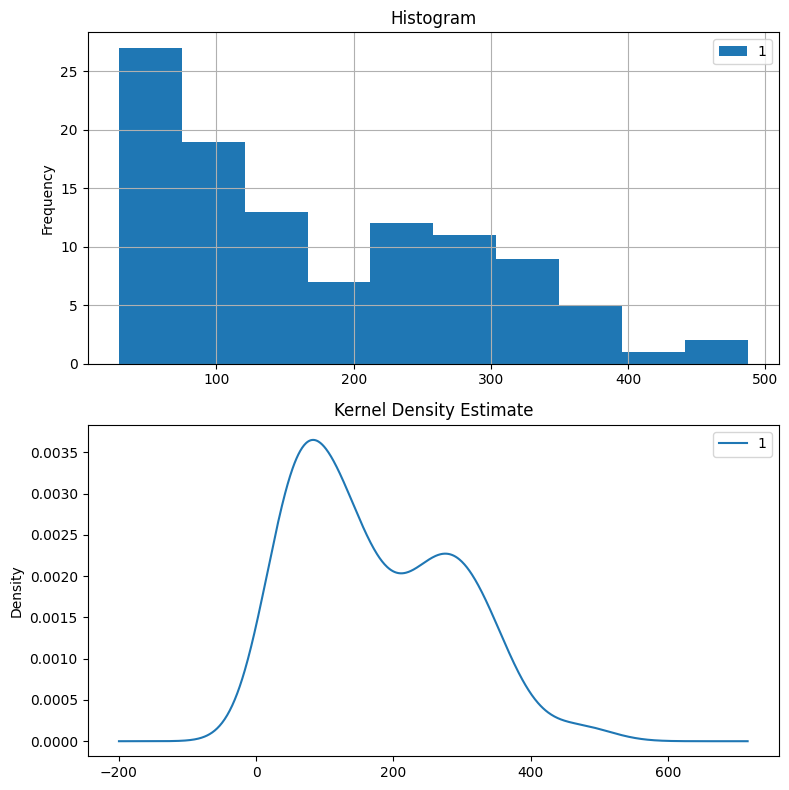

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))  # Create a 2-row layout

# Plot histogram on the first subplot
series.plot(kind='hist', ax=axes[0], title="Histogram")
axes[0].grid(True)

# Plot kernel density estimate (KDE) on the second subplot
series.plot(kind='kde', ax=axes[1], title="Kernel Density Estimate")

plt.tight_layout()
plt.show()

### Box and Whisker Plots

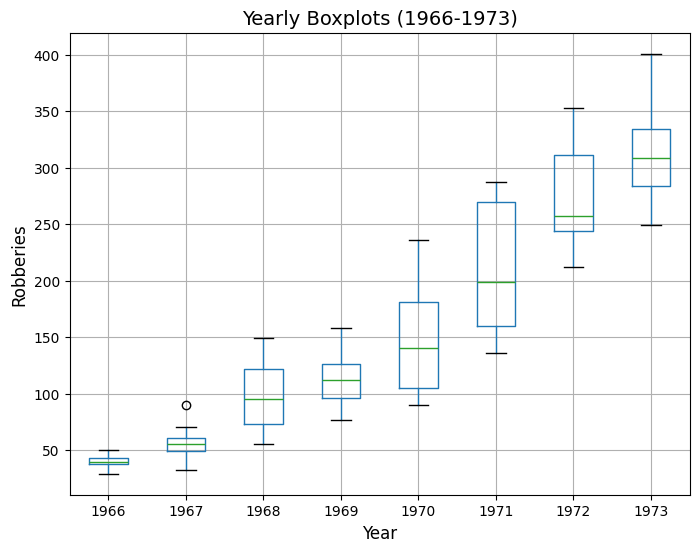

In [ ]:
# Group the data by year ('YE')
groups = series['1966':'1973'].groupby(pd.Grouper(freq='YE'))

# Create a DataFrame to store yearly values for boxplots
years = pd.DataFrame({name.year: group.squeeze().values for name, group in groups})

# Plot boxplots
fig, ax = plt.subplots(figsize=(8, 6))
years.boxplot(ax=ax)
ax.set_title("Yearly Boxplots (1966-1973)", fontsize=14)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Robberies", fontsize=12)
ax.grid(True)
plt.show()

## SARIMAX Models

### Manually Configured SARIMAX
The results show that the test statistic value -3.980946 is smaller than the critical value at 5% of -2.893. This suggests that we can reject the null hypothesis with a significance level of less than 5% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that <strong>the 1-lag differenced time series is stationary</strong> or does not have time-dependent structure. This suggests that at least one level of differencing is required. The d parameter in our ARIMA model should at least be a value of 1.

In [ ]:
X = series

# Difference the data to make it stationary
stationary = X.diff().dropna() # X[i] - X[i - 1]

# Perform the Augmented Dickey-Fuller test
result = adfuller(stationary)

print(f"ADF Statistic: {result[0]:.6f}")
print(f"p-value: {result[1]:.6f}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value:.3f}")

stationary.to_csv('stationary.csv', index=True, header=False)

ADF Statistic: -3.980946
p-value: 0.001514
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


- The ACF shows a significant lag for 10-11 months.
- The PACF shows a significant lag for perhaps 2 months.
- A good starting point for the p and q values are 11 and 2.
- This quick analysis suggests an ARIMA(11,1,2) on the raw data may be a good starting point.
- The RMSE value for this model is not less than the baseline, so a grid search might be helpful.

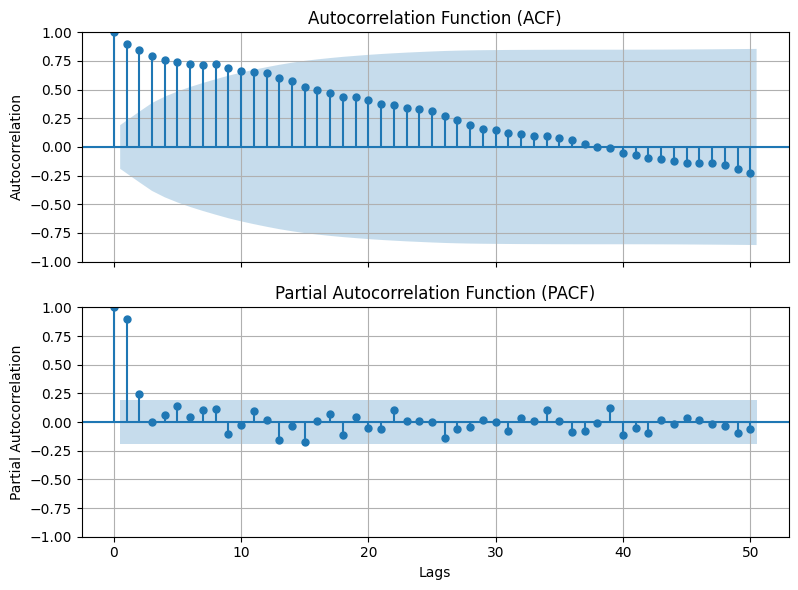

In [ ]:
# Create a figure with two subplots: one for ACF and one for PACF
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot the ACF in the first subplot
plot_acf(series, lags=50, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")
axes[0].set_ylabel("Autocorrelation")
axes[0].grid(True)

# Plot the PACF in the second subplot
plot_pacf(series, lags=50, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")
axes[1].set_xlabel("Lags")
axes[1].set_ylabel("Partial Autocorrelation")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Split into train and test sets
X = series.values
X = X.astype('float32')
size = int(len(X) * 0.50)
train, test = X[:size], X[size:]

history = list(train)
predictions = []
p, d, q = 0, 1, 2

# Walk-forward validation
for t in range(len(test)):
    model = SARIMAX(history, order=(p, d, q), enforce_stationarity=True,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=1)  # Forecast next step
    yhat = forecast[0]  # Extract the scalar value
    predictions.append(yhat)
    obs = test[t]  # Extract the scalar value
    history.append(obs)
    print(f"predicted={yhat:.3f}, expected={obs[0]:.3f}")

# Evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print(f"Test RMSE: {rmse:.3f}")

predicted=99.922, expected=125.000
predicted=116.442, expected=155.000
predicted=139.963, expected=190.000
predicted=176.933, expected=236.000
predicted=232.852, expected=189.000
predicted=184.697, expected=174.000
predicted=180.705, expected=178.000
predicted=179.873, expected=136.000
predicted=141.098, expected=161.000
predicted=166.172, expected=171.000
predicted=167.005, expected=149.000
predicted=150.657, expected=184.000
predicted=182.314, expected=155.000
predicted=154.213, expected=276.000
predicted=245.215, expected=224.000
predicted=225.903, expected=213.000
predicted=216.868, expected=279.000
predicted=258.698, expected=268.000
predicted=263.379, expected=287.000
predicted=279.945, expected=238.000
predicted=251.485, expected=213.000
predicted=226.574, expected=257.000
predicted=249.690, expected=293.000
predicted=277.210, expected=212.000
predicted=230.020, expected=246.000
predicted=245.786, expected=353.000
predicted=317.991, expected=339.000
predicted=313.735, expected=3

### Grid Search SARIMAX Hyperparameters

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = list(train)
    # make predictions
    predictions = []
    for t in range(len(test)):
        model = SARIMAX(history, order=arima_order, enforce_stationarity=True,
                        enforce_invertibility=False,)
        model_fit = model.fit(disp=False)
        forecast = model_fit.forecast(steps=1)  # Forecast next step
        yhat = forecast[0]  # Extract the scalar value
        predictions.append(yhat)
        history.append(test[t])

    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


# evaluate parameters
p_values = range(0,13)
d_values = range(0, 4)
q_values = range(0, 13)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

### Review Residual Errors
The above grid search uncovered that the best parameters are p, d, q = 0, 1, 2 and below is a residual analysis for a model with these parameters.
The graphs suggest a Gaussian-like distribution with a longer right tail. This is perhaps a sign that the predictions are biased, and in this case that perhaps a power-based transform of the raw data before modeling might be useful.

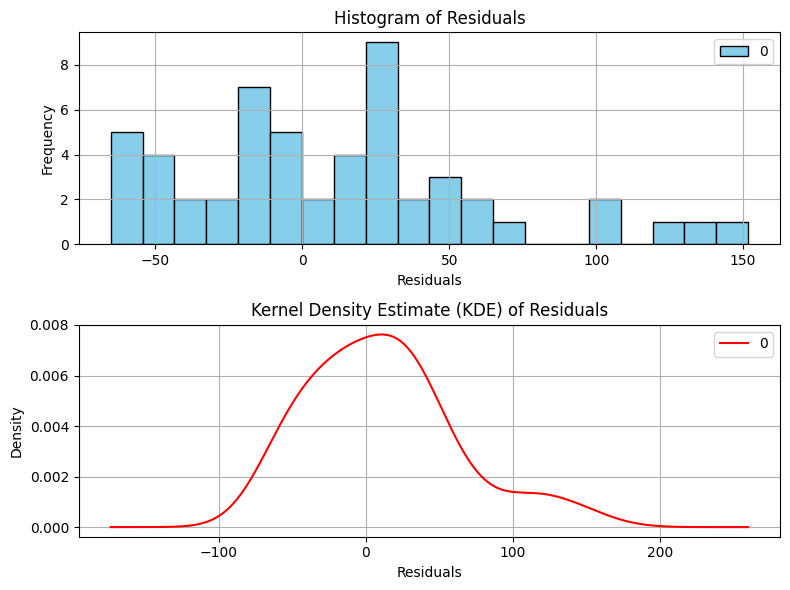

In [ ]:
# Split into train and test sets
X = series.values
X = X.astype('float32')
size = int(len(X) * 0.50)
train, test = X[:size], X[size:]

history = list(train)
predictions = []
p, d, q = 0, 1, 2 # best model after grid search

# Walk-forward validation
for t in range(len(test)):
    model = SARIMAX(history, order=(p, d, q), enforce_stationarity=True,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=1)  # Forecast next step
    yhat = forecast[0]  # Extract the scalar value
    predictions.append(yhat)
    obs = test[t]  # Extract the scalar value
    history.append(obs)

# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Plot the histogram in the first subplot
residuals.plot(kind='hist', bins=20, ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Residuals')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot the KDE in the second subplot
residuals.plot(kind='kde', ax=axes[1], color='red')
axes[1].set_title('Kernel Density Estimate (KDE) of Residuals')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].grid(True)

plt.tight_layout()
plt.show()

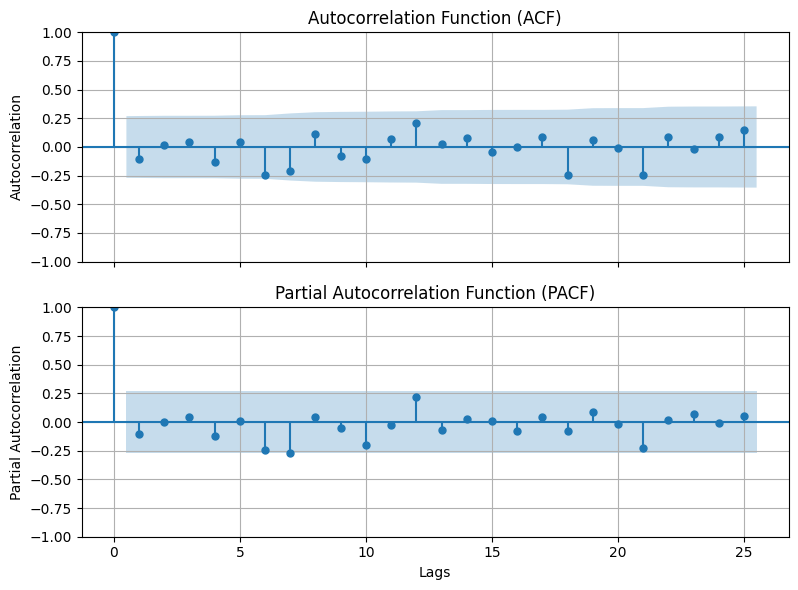

In [ ]:
# Create a figure with two subplots: one for ACF and one for PACF
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot the ACF in the first subplot
plot_acf(residuals, lags=25, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")
axes[0].set_ylabel("Autocorrelation")
axes[0].grid(True)

# Plot the PACF in the second subplot
plot_pacf(residuals, lags=25, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")
axes[1].set_xlabel("Lags")
axes[1].set_ylabel("Partial Autocorrelation")
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Box-Cox Transformed Dataset

Stabilizing variance before applying ARIMA or other forecasting models.

---

Function to transform the data:

    log(x), IF lambda = 0
    ---------------------------
    (x^lambda - 1) / lambda, IF lambda ≠ 0

This transform function can be reversed directly, as follows:

    exp(transform), IF lambda = 0
    ---------------------------------------------
    exp(log(lambda * transform + 1) / lambda), IF lambda ≠ 0

---

Utilize Q-Q plot to see how normal is the destribution of the transformed data.

Lambda: 0.260060


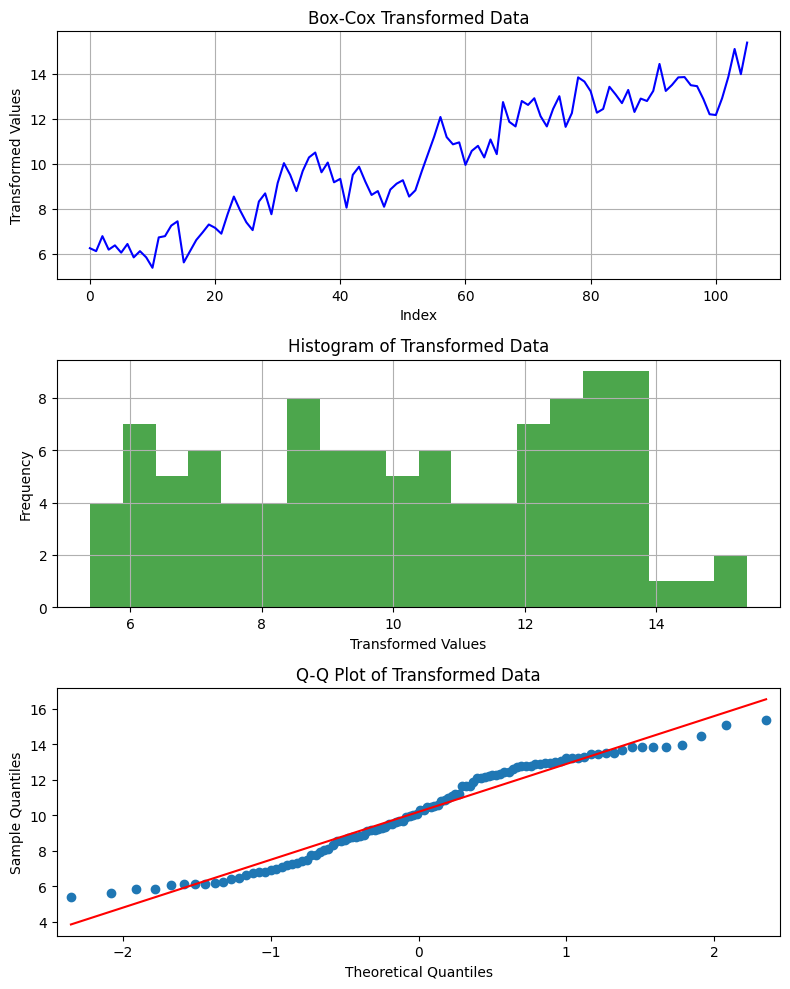

In [ ]:
X = series.squeeze().values  # Convert to 1D array

# Apply Box-Cox transformation
transformed, lam = boxcox(X)
print(f'Lambda: {lam:.6f}')

# Create plots
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

# Line plot of transformed data
axes[0].plot(transformed, color='blue')
axes[0].set_title('Box-Cox Transformed Data')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Transformed Values')
axes[0].grid(True)

# Histogram of transformed data
axes[1].hist(transformed, bins=20, color='green', alpha=0.7)
axes[1].set_title('Histogram of Transformed Data')
axes[1].set_xlabel('Transformed Values')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

# Q-Q plot
qqplot(transformed, line='r', ax=axes[2])
axes[2].set_title('Q-Q Plot of Transformed Data')

plt.tight_layout()
plt.show()

In [ ]:
# invert box-cox transform
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)

# Split into train and test sets
X = series.squeeze().values  # Convert to 1D array
X = X.astype('float32')
size = int(len(X) * 0.50)
train, test = X[:size], X[size:]

history = list(train)
predictions = []
# the best parameters achieved after grid search (but on not-transformed data)
p, d, q = 0, 1, 2

# Walk-forward validation
for t in range(len(test)):
    # transform
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1 # don't transform
    model = SARIMAX(transformed, order=(p, d, q), enforce_stationarity=True,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=1)  # Forecast next step
    yhat = forecast[0]  # Extract the scalar value
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    obs = test[t]  # Extract the scalar value
    history.append(obs)
    print(f"predicted={yhat:.3f}, expected={obs:.3f}")

# Evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print(f"Test RMSE: {rmse:.3f}")

predicted=99.650, expected=125.000
predicted=115.213, expected=155.000
predicted=136.146, expected=190.000
predicted=165.525, expected=236.000
predicted=206.477, expected=189.000
predicted=180.935, expected=174.000
predicted=178.195, expected=178.000
predicted=179.314, expected=136.000
predicted=145.466, expected=161.000
predicted=165.568, expected=171.000
predicted=166.483, expected=149.000
predicted=152.065, expected=184.000
predicted=179.560, expected=155.000
predicted=155.212, expected=276.000
predicted=238.978, expected=224.000
predicted=210.760, expected=213.000
predicted=214.076, expected=279.000
predicted=257.445, expected=268.000
predicted=255.409, expected=287.000
predicted=275.941, expected=238.000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=245.091, expected=213.000
predicted=226.698, expected=257.000
predicted=252.344, expected=293.000
predicted=275.299, expected=212.000
predicted=224.656, expected=246.000
predicted=248.230, expected=353.000
predicted=313.576, expected=339.000
predicted=312.855, expected=308.000
predicted=305.389, expected=247.000
predicted=263.453, expected=257.000
predicted=268.874, expected=322.000
predicted=307.068, expected=298.000
predicted=290.762, expected=273.000
predicted=279.628, expected=312.000
predicted=305.831, expected=249.000
predicted=259.479, expected=286.000
predicted=288.086, expected=279.000
predicted=277.060, expected=309.000
predicted=300.444, expected=401.000
predicted=361.793, expected=309.000
predicted=307.486, expected=328.000
predicted=330.340, expected=353.000
predicted=342.083, expected=354.000
predicted=346.257, expected=327.000
predicted=330.893, expected=324.000
predicted=329.470, expected=285.000
predicted=299.526, expected=243.000
predicted=266.151, expected=

## Model Validation

### Finalize Model
Fit the model on the whole train dataset (without spliting) after applying transformation, and save it.

In [ ]:
series = pd.read_csv('data/monthly-robberies-dataset.csv', header=None,
                     index_col=0, parse_dates=True)

X = series.squeeze().values
X = X.astype('float32')
# transform data
transformed, lam = boxcox(X)
# fit model
# the best parameters achieved after grid search (but on not-transformed data)
p, d, q = 0, 1, 2
model = SARIMAX(transformed, order=(p, d, q), enforce_stationarity=True,
                enforce_invertibility=False)
model_fit = model.fit(disp=0)
# save model
model_fit.save('forecasting_monthly_armed_robberies_in_boston.pkl')
np.save('model_lambda.npy', [lam])

In [ ]:
!ls

data  forecasting_monthly_armed_robberies_in_boston.pkl  model_lambda.npy  sample_data


### Make Prediction
Predict the next value and compare it with the real data (the first value in the validation dataset).

In [ ]:
# load the finalized model and make a prediction
model_fit = SARIMAXResults.load('forecasting_monthly_armed_robberies_in_boston.pkl')
lam = np.load('model_lambda.npy')
forecast = model_fit.forecast(steps=1)  # Forecast next step
yhat = forecast[0]  # Extract the scalar value
yhat = boxcox_inverse(yhat, lam[0])
print('Predicted: %.3f' % yhat)

Predicted: 452.367


In [ ]:
validation = pd.read_csv('data/monthly-robberies-validation.csv', header=None,
                         index_col=0, parse_dates=True)
validation.head(1)

,1
0,
1974-11-01,452


### Validate Model

In [ ]:
# invert box-cox transform
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)

# Split into train and test sets
series = pd.read_csv('data/monthly-robberies-dataset.csv', header=None,
                     index_col=0, parse_dates=True)
X = series.squeeze().values  # Convert to 1D array
X = X.astype('float32')
history = list(X)
predictions = []

validation = pd.read_csv('data/monthly-robberies-validation.csv', header=None,
                         index_col=0, parse_dates=True)
y = validation.squeeze().values  # Convert to 1D array
y = y.astype('float32')

# load the finalized model and make first prediction
model_fit = SARIMAXResults.load('forecasting_monthly_armed_robberies_in_boston.pkl')
lam = np.load('model_lambda.npy')
forecast = model_fit.forecast(steps=1)  # Forecast next step
yhat = forecast[0]  # Extract the scalar value
yhat = boxcox_inverse(yhat, lam[0])

predictions.append(yhat)
history.append(y[0])
print(f"predicted={yhat:.3f}, expected={y[0]:.3f}")

# the best parameters achieved after grid search (but on not-transformed data)
p, d, q = 0, 1, 2
# Walk-forward validation
for t in range(1, len(y)):
    # transform
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1 # don't transform
    model = SARIMAX(transformed, order=(p, d, q), enforce_stationarity=True,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=1)  # Forecast next step
    yhat = forecast[0]  # Extract the scalar value
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    obs = y[t]  # Extract the scalar value
    history.append(obs)
    print(f"predicted={yhat:.3f}, expected={obs:.3f}")

# Evaluate forecasts
rmse = sqrt(mean_squared_error(y, predictions))
print(f"Test RMSE: {rmse:.3f}")

predicted=452.367, expected=452.000
predicted=429.901, expected=391.000
predicted=401.394, expected=500.000
predicted=476.461, expected=451.000
predicted=442.453, expected=375.000
predicted=397.526, expected=372.000
predicted=390.647, expected=302.000
predicted=329.394, expected=316.000
predicted=334.172, expected=398.000
predicted=382.821, expected=394.000
predicted=378.508, expected=431.000
predicted=413.524, expected=431.000
Test RMSE: 51.949


<Axes: >

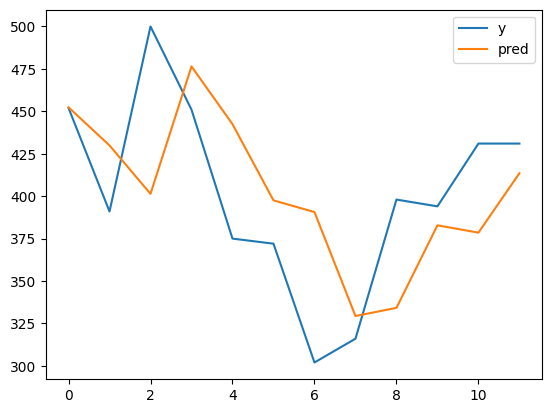

In [ ]:
y_and_pred = pd.DataFrame({'y': y, 'pred': predictions})
y_and_pred.plot()

## Not considering the first two years of data as they are very different from the rest

In [ ]:
# invert box-cox transform
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)

# Split into train and test sets
series = pd.read_csv('data/monthly-robberies-dataset.csv', header=None,
                     index_col=0, parse_dates=True)
X = series.squeeze().values  # Convert to 1D array
X = X.astype('float32')
X = X[24:]
history = list(X)
predictions = []

validation = pd.read_csv('data/monthly-robberies-validation.csv', header=None,
                         index_col=0, parse_dates=True)
y = validation.squeeze().values  # Convert to 1D array
y = y.astype('float32')

# the best parameters achieved after grid search (but on not-transformed data)
p, d, q = 0, 1, 2
# Walk-forward validation
for t in range(len(y)):
    # transform
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1 # don't transform
    model = SARIMAX(transformed, order=(p, d, q), enforce_stationarity=True,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=1)  # Forecast next step
    yhat = forecast[0]  # Extract the scalar value
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    obs = y[t]  # Extract the scalar value
    history.append(obs)
    print(f"predicted={yhat:.3f}, expected={obs:.3f}")

# Evaluate forecasts
rmse = sqrt(mean_squared_error(y, predictions))
print(f"Test RMSE: {rmse:.3f}")

predicted=454.378, expected=452.000
predicted=434.104, expected=391.000
predicted=402.248, expected=500.000
predicted=477.170, expected=451.000
predicted=444.630, expected=375.000
predicted=397.503, expected=372.000
predicted=390.043, expected=302.000
predicted=328.409, expected=316.000
predicted=332.215, expected=398.000
predicted=382.850, expected=394.000
predicted=378.812, expected=431.000
predicted=414.057, expected=431.000
Test RMSE: 52.417


# Predict using XGBoost 2.0 model

Accuracy might be improved by a grid search (even without it the below second model's RMSE is considerably lower than all previous models).

https://kaabar-sofien.medium.com/xgboost-2-0-is-here-to-improve-your-time-series-forecasts-98fd35aaca40

In [ ]:
def get_mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)
def get_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))
def get_rmse(y_true, y_pred):
    return np.sqrt(get_mse(y_true, y_pred))


def get_scores(y_true, y_pred):
    """given true and predicted values, return mse, mae, rmse"""
    return get_mse(y_true, y_pred), get_mae(y_true, y_pred), get_rmse(y_true, y_pred)


def data_preprocessing(data, num_lags, test_len=12):
    # Prepare the data for training
    x = []
    y = []
    for i in range(len(data) - num_lags):
        x.append(data[i:i + num_lags])
        y.append(data[i+ num_lags])
    # Convert the data to numpy arrays
    x = np.array(x)
    y = np.array(y)
    # Split the data into training and testing sets
    x_train = x[:-test_len]
    y_train = y[:-test_len]
    x_test = x[-test_len:]
    y_test = y[-test_len:]

    return x_train, y_train, x_test, y_test


url = "https://raw.githubusercontent.com/jbrownlee/Datasets/refs/heads/master/monthly-robberies.csv"
series = pd.read_csv(url, header=0, index_col=0, parse_dates=True)
series = np.reshape(series.values, (-1))
data = np.diff(series)

MSE: 3252.1974, MAE: 43.2373, RMSE: 57.0280


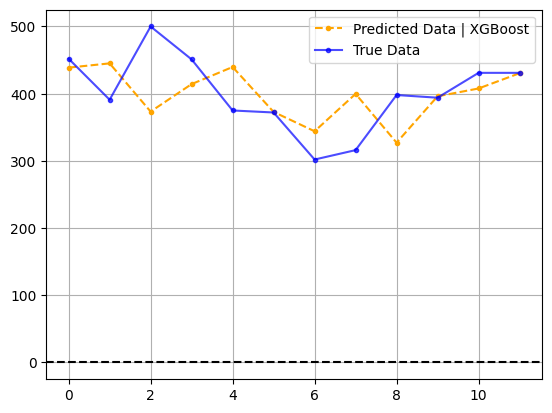

In [ ]:
test_len = 12
x_train, y_train, x_test, y_test = data_preprocessing(data, 24, test_len)

# Create the model
model = XGBRegressor(random_state = 0, n_estimators = 64, max_depth = 64)

# Fit the model to the data
model.fit(x_train, y_train)
y_pred_xgb = model.predict(x_test)

# inverse diff to get the real predictions
real_preds = []
for i in range(len(y_pred_xgb)):
    real_preds.append(y_pred_xgb[i] + series[-test_len-1+i])

# Plotting
plt.plot(real_preds, label='Predicted Data | XGBoost', linestyle='--',
         marker = '.', color = 'orange')
plt.plot(series[-test_len:], label='True Data', marker = '.', alpha = 0.7, color = 'blue')
plt.legend()
plt.grid()
plt.axhline(y = 0, color = 'black', linestyle = '--')

# Convert predictions to numpy array for scoring
scores = get_scores(series[-test_len:], np.array(real_preds))
print(f"MSE: {scores[0]:.4f}, MAE: {scores[1]:.4f}, RMSE: {scores[2]:.4f}")

MSE: 2284.8999, MAE: 36.6995, RMSE: 47.8006


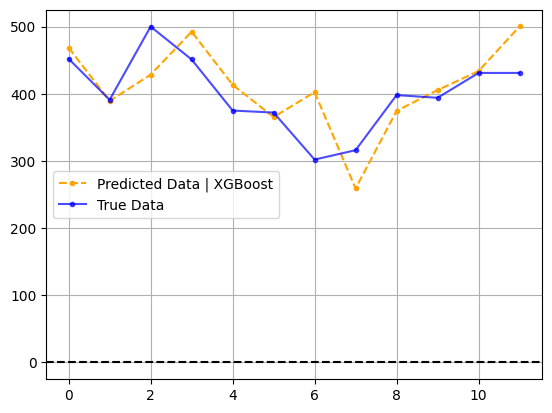

In [ ]:
test_len = 12
real_preds = []
for s in range(test_len):
    x_train, y_train, x_test, y_test = data_preprocessing(data[:-test_len+s], 12, 1)

    # Create the model
    model = XGBRegressor(random_state = 0, n_estimators = 6, max_depth = 20)

    # Fit the model to the data
    model.fit(x_train, y_train)
    y_pred_xgb = model.predict(x_test)

    # inverse diff to get the real predictions
    real_preds.append(y_pred_xgb[0] + series[-test_len+s-1])

# Plotting
plt.plot(real_preds, label='Predicted Data | XGBoost', linestyle='--',
         marker = '.', color = 'orange')
plt.plot(series[-12:], label='True Data', marker = '.', alpha = 0.7, color = 'blue')
plt.legend()
plt.grid()
plt.axhline(y = 0, color = 'black', linestyle = '--')

# Convert predictions to numpy array for scoring
scores = get_scores(series[-12:], np.array(real_preds))
print(f"MSE: {scores[0]:.4f}, MAE: {scores[1]:.4f}, RMSE: {scores[2]:.4f}")

# Predict using Amazon's time series forecasting model
Each time I run the model to predict and measure its accuracy, a different result is achieved. This is because the deep learning model requires more data and a method like cross-validation to obtain a more reliable accuracy value.

https://towardsdatascience.com/how-to-effectively-forecast-time-series-with-amazons-new-time-series-forecasting-model-9e04d4ccf67e

https://github.com/amazon-science/chronos-forecasting?tab=readme-ov-file

In [ ]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-_6uey0_d
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-_6uey0_d
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 133761a90145f77971a08c49bfc7cca318b2df9b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 11.0 MB/s eta 0:00:00
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.4.1-py3-none-any.whl size=28756 sha256=d5dc5b2abf7c97e21c6a5f0d7e761f0e5800232a121505bb013dbc4e75af7ada
  Stored in directory: /tmp/pip-ephem-wheel-cache-n27meidd/wheels/bf/c1/65/08857e57345ef1b34ba0edb4791f1b2594943e82f34e93a4ab
Successfully built chronos-forecasting
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.1.

In [ ]:
!pip install pandas
!pip install numpy
!pip install tqdm

In [ ]:
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline
from tqdm.auto import tqdm

def load_model():
    pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
    )
    return pipeline

def predict(pipeline: ChronosPipeline, timeseries: torch.Tensor,
            prediction_length: int = 12) -> np.ndarray:
    """given a timeseries, predict with chronos model"""
    forecast = pipeline.predict(timeseries, prediction_length,
                                num_samples=1)[0][0]
                                # shape [num_series, num_samples, prediction_length]
    return forecast

def get_mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)
def get_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))
def get_rmse(y_true, y_pred):
    return np.sqrt(get_mse(y_true, y_pred))

def get_scores(y_true, y_pred):
    """given true and predicted values, return mse, mae, rmse"""
    return get_mse(y_true, y_pred), get_mae(y_true, y_pred), get_rmse(y_true, y_pred)

series = pd.read_csv('data/monthly-robberies-dataset.csv', header=None,
                     index_col=0, parse_dates=True)
X = series.to_numpy()
X = X.reshape(-1)

validation = pd.read_csv('data/monthly-robberies-validation.csv', header=None,
                         index_col=0, parse_dates=True)
y = validation.to_numpy()
y = y.reshape(-1)

pipeline = load_model()
predictions = []
X_list = X.tolist()
y_list = y.tolist()
for i, obs in tqdm(enumerate(y), total=len(y)):
    forecast = predict(pipeline, torch.tensor(X_list), prediction_length=1)
    predictions.append(forecast.tolist()[0])
    X_list.append(obs)

# Convert predictions to numpy array for scoring
scores = get_scores(y, np.array(predictions))
print(f"MSE: {scores[0]:.4f}, MAE: {scores[1]:.4f}, RMSE: {scores[2]:.4f}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

  0%|          | 0/12 [00:00<?, ?it/s]

MSE: 3139.4850, MAE: 42.5151, RMSE: 56.0311


<Axes: >

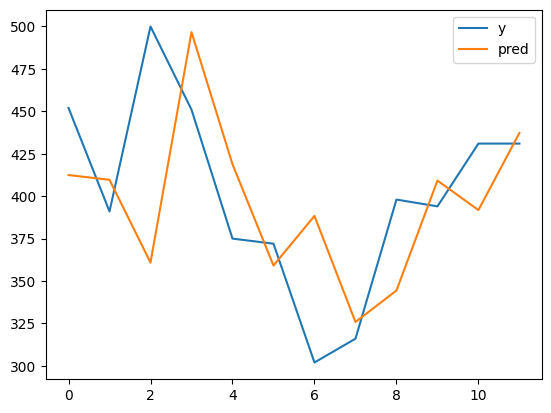

In [ ]:
y_and_pred = pd.DataFrame({'y': y, 'pred': predictions})
y_and_pred.plot()

In [ ]:
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline
from tqdm.auto import tqdm

def load_model():
    pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
    )
    return pipeline

def predict(pipeline: ChronosPipeline, timeseries: torch.Tensor,
            prediction_length: int = 12) -> np.ndarray:
    """given a timeseries, predict with chronos model"""
    forecast = pipeline.predict(timeseries, prediction_length,
                                num_samples=1)[0][0]
                                # shape [num_series, num_samples, prediction_length]
    return forecast

def get_mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)
def get_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))
def get_rmse(y_true, y_pred):
    return np.sqrt(get_mse(y_true, y_pred))

def get_scores(y_true, y_pred):
    """given true and predicted values, return mse, mae, rmse"""
    return get_mse(y_true, y_pred), get_mae(y_true, y_pred), get_rmse(y_true, y_pred)

series = pd.read_csv('data/monthly-robberies-dataset.csv', header=None,
                     index_col=0, parse_dates=True)
X = series.to_numpy()
X = X.reshape(-1)

validation = pd.read_csv('data/monthly-robberies-validation.csv', header=None,
                         index_col=0, parse_dates=True)
y = validation.to_numpy()
y = y.reshape(-1)

pipeline = load_model()
predictions = []
X_list = X.tolist()
y_list = y.tolist()

# now test the model. Given the last x values, predict the next y values,
# then we can calculate metrics like MSE, RMSE, MAE
CONTEXT_LENGTH = 106
PREDICTION_LENGTH = 1

X = X_list + y_list
mse_scores, mae_scores, rmse_scores = [], [], []
for i in tqdm(range(0, len(X))):
    print('i: ', i)
    if (i+CONTEXT_LENGTH+PREDICTION_LENGTH) > len(X):
        print('break')
        break
    prediction = predict(pipeline, torch.tensor(X[i:i+CONTEXT_LENGTH]), PREDICTION_LENGTH)
    ground_truth = X[i+CONTEXT_LENGTH:i+CONTEXT_LENGTH+PREDICTION_LENGTH]

    mse, mae, rmse = get_scores(ground_truth, prediction.numpy())
    mse_scores.append(mse), mae_scores.append(mae), rmse_scores.append(rmse)